In [1]:
!pip -q install -U transformers accelerate datasets scikit-learn joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.7 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()


Saving arb_clean_dev.csv to arb_clean_dev.csv
Saving arb_clean_train.csv to arb_clean_train.csv


In [3]:
import os, json
import numpy as np
import pandas as pd
import torch

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import joblib

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    set_seed
)


In [4]:
# Put the exact uploaded filenames here
TRAIN_CSV = "arb_clean_train.csv"
DEV_CSV   = "arb_clean_dev.csv"

train_df = pd.read_csv(TRAIN_CSV)
dev_df   = pd.read_csv(DEV_CSV)

train_df.head(), dev_df.head()


(                                     id  \
 0  arb_a2a60c8b4af3389e842d8ec31afb0eea   
 1  arb_6723e56a672674a6c1d9b28b213c4a05   
 2  arb_b0365d606edeee38ae6c025b1ca33e96   
 3  arb_858c0ee684049ba6f416a6cecb0b0761   
 4  arb_bdafc73afd0bc2cd2badae2a089446b9   
 
                                                 text  political  \
 0  احلام انتي ونعالي ومنو انتي حتي تقيمين الفناني...          0   
 1  وره الكواليس تنيجج من وره بعير صطناعي علي فكرة...          0   
 2  .خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...          0   
 3  الله يخزي احلام هي والبرنامج الخايس الي كله مصخره          0   
 4  كس ام احلام الي ماربتها وش ملكه هههه متستاهل م...          0   
 
    racial/ethnic  religious  gender/sexual  other  
 0              0          0              1      1  
 1              0          0              1      1  
 2              0          0              1      1  
 3              0          0              1      1  
 4              0          0              0      1  ,
     

In [5]:
TRAIN_TEXT_COL = "text"
DEV_TEXT_COL   = "text_clean"

LABEL_COLS = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

# Train must have id + train text + labels
missing_train = [c for c in ["id", TRAIN_TEXT_COL, *LABEL_COLS] if c not in train_df.columns]
if missing_train:
    raise ValueError(f"Missing columns in TRAIN: {missing_train}")

# Dev must have id + dev text (unlabeled)
missing_dev = [c for c in ["id", DEV_TEXT_COL] if c not in dev_df.columns]
if missing_dev:
    raise ValueError(f"Missing columns in DEV: {missing_dev}")

train_df[LABEL_COLS] = train_df[LABEL_COLS].astype(int)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    random_state=45,
)

print("Train split:", train_df.shape)
print("Val split:  ", val_df.shape)
print("Dev (unlabeled):", dev_df.shape)


Train split: (2873, 7)
Val split:   (507, 7)
Dev (unlabeled): (169, 2)


In [6]:
MODEL_NAME = "UBC-NLP/MARBERTv2"

RANDOM_SEED = 45
EPOCHS = 4
BATCH_SIZE = 16
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 500
MAX_LEN = 256

NUM_SNAPSHOTS = 4  # snapshot ensemble size

set_seed(RANDOM_SEED)


In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class MultiLabelTextDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, text_col, label_cols, max_len=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.label_cols = label_cols
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, self.text_col])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        labels = self.df.loc[idx, self.label_cols].values.astype(np.float32)
        item["labels"] = torch.tensor(labels, dtype=torch.float32)
        return item

train_ds = MultiLabelTextDataset(train_df, tokenizer, TRAIN_TEXT_COL, LABEL_COLS, max_len=MAX_LEN)
val_ds   = MultiLabelTextDataset(val_df,   tokenizer, TRAIN_TEXT_COL, LABEL_COLS, max_len=MAX_LEN)
dev_ds   = MultiLabelTextDataset(dev_df,   tokenizer, DEV_TEXT_COL,   LABEL_COLS, max_len=MAX_LEN)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
class AsymmetricLoss(torch.nn.Module):
    def __init__(self, gamma_neg=4.0, gamma_pos=1.0, clip=0.05, eps=1e-8):
        super().__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, logits, targets):
        prob = torch.sigmoid(logits)

        if self.clip is not None and self.clip > 0:
            prob_neg = (1.0 - prob).clamp(min=self.eps)
            prob_neg = (prob_neg + self.clip).clamp(max=1.0)
            prob = 1.0 - prob_neg

        pos_loss = targets * torch.log(prob.clamp(min=self.eps))
        neg_loss = (1.0 - targets) * torch.log((1.0 - prob).clamp(min=self.eps))

        pt_pos = prob
        pt_neg = 1.0 - prob

        w_pos = torch.pow(1.0 - pt_pos, self.gamma_pos)
        w_neg = torch.pow(1.0 - pt_neg, self.gamma_neg)

        loss = -(w_pos * pos_loss + w_neg * neg_loss)
        return loss.mean()

asl = AsymmetricLoss(gamma_neg=4.0, gamma_pos=1.0, clip=0.05)

class ASLTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = asl(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [9]:
class SnapshotCallback(TrainerCallback):
    def __init__(self, out_dir, num_snapshots, tokenizer):
        self.out_dir = out_dir
        self.num_snapshots = num_snapshots
        self.tokenizer = tokenizer
        self.snapshots = []
        self.boundaries = None

    def on_train_begin(self, args, state, control, **kwargs):
        total_steps = state.max_steps
        steps_per_cycle = max(1, total_steps // self.num_snapshots)
        self.boundaries = set([steps_per_cycle * (i+1) for i in range(self.num_snapshots)])
        return control

    def on_step_end(self, args, state, control, **kwargs):
        if self.boundaries and state.global_step in self.boundaries:
            snap_dir = os.path.join(self.out_dir, f"snapshot_step_{state.global_step}")
            os.makedirs(snap_dir, exist_ok=True)

            model = kwargs["model"]
            model.save_pretrained(snap_dir)

            # Save tokenizer from self (not kwargs)
            if self.tokenizer is not None:
                self.tokenizer.save_pretrained(snap_dir)

            self.snapshots.append(snap_dir)
            print(f"\n[SAVED SNAPSHOT] step={state.global_step} -> {snap_dir}\n")
        return control


OUT_DIR = "subtask2_ensemble"
os.makedirs(OUT_DIR, exist_ok=True)

training_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "results"),
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="no",
    seed=RANDOM_SEED,
    fp16=True,
    report_to="none",
    lr_scheduler_type="cosine_with_restarts"
)


In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_COLS),
)

snap_cb = SnapshotCallback(out_dir=OUT_DIR, num_snapshots=NUM_SNAPSHOTS, tokenizer=tokenizer)


trainer = ASLTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,   # <-- MUST be val, because it has labels
    tokenizer=tokenizer,
    callbacks=[snap_cb],
)

trainer.train()
snapshot_dirs = snap_cb.snapshots
snapshot_dirs


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2085905503.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `ASLTrainer.__init__`. Use `processing_class` instead.
  trainer = ASLTrainer(


model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.080400,0.074448
2,0.056000,0.060121
3,0.042400,0.064417
4,0.025800,0.062113



[SAVED SNAPSHOT] step=180 -> subtask2_ensemble/snapshot_step_180


[SAVED SNAPSHOT] step=360 -> subtask2_ensemble/snapshot_step_360


[SAVED SNAPSHOT] step=540 -> subtask2_ensemble/snapshot_step_540


[SAVED SNAPSHOT] step=720 -> subtask2_ensemble/snapshot_step_720



['subtask2_ensemble/snapshot_step_180',
 'subtask2_ensemble/snapshot_step_360',
 'subtask2_ensemble/snapshot_step_540',
 'subtask2_ensemble/snapshot_step_720']

In [11]:
def predict_probs(model_dir, dataset, batch_size=16, device="cuda"):
    m = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device)
    m.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_probs = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            logits = m(**batch).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
    return np.vstack(all_probs)

val_y = val_df[LABEL_COLS].values.astype(int)

snap_probs = []
for d in snapshot_dirs:
    snap_probs.append(predict_probs(d, val_ds, batch_size=BATCH_SIZE))

snap_probs = np.stack(snap_probs, axis=-1)  # (n_val, L, S)
snap_probs.shape

(507, 5, 4)

In [12]:
# X for validation (snap_probs came from val_ds)
X_val = snap_probs.reshape(len(val_df), len(LABEL_COLS) * len(snapshot_dirs))

meta = OneVsRestClassifier(
    LogisticRegression(max_iter=2000, solver="liblinear")
)
meta.fit(X_val, val_y)

val_meta_probs = meta.predict_proba(X_val)  # (n_val, L)

def best_thresholds(y_true, y_prob, steps=91):
    ts = np.linspace(0.05, 0.95, steps)
    best_t, best_f = [], []
    for j in range(y_true.shape[1]):
        scores = []
        for t in ts:
            pred = (y_prob[:, j] >= t).astype(int)
            scores.append(f1_score(y_true[:, j], pred, zero_division=0))
        k = int(np.argmax(scores))
        best_t.append(float(ts[k]))
        best_f.append(float(scores[k]))
    return best_t, best_f

thr, f1s = best_thresholds(val_y, val_meta_probs)

for name, t, f in zip(LABEL_COLS, thr, f1s):
    print(f"{name:>14}  thr={t:.2f}  f1={f:.4f}")

pred_val = np.zeros_like(val_y)
for j, t in enumerate(thr):
    pred_val[:, j] = (val_meta_probs[:, j] >= t).astype(int)

macro = f1_score(val_y, pred_val, average="macro", zero_division=0)
print("\nVAL Macro-F1:", macro)


     political  thr=0.33  f1=0.8082
 racial/ethnic  thr=0.39  f1=0.6701
     religious  thr=0.27  f1=0.5946
 gender/sexual  thr=0.27  f1=0.6387
         other  thr=0.44  f1=0.6826

VAL Macro-F1: 0.6788414116368175


In [13]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
import pandas as pd

# Apply thresholds to validation
val_preds = np.zeros_like(val_y)
for j, t in enumerate(thr):
    val_preds[:, j] = (val_meta_probs[:, j] >= t).astype(int)

rows = []
for i, label in enumerate(LABEL_COLS):
    p, r, f1, _ = precision_recall_fscore_support(
        val_y[:, i], val_preds[:, i], average="binary", zero_division=0
    )
    rows.append({
        "label": label,
        "precision": p,
        "recall": r,
        "f1": f1,
        "threshold": thr[i]
    })

metrics_df = pd.DataFrame(rows)
metrics_df


,label,precision,recall,f1,threshold
0,political,0.746835,0.880597,0.808219,0.33
1,racial/ethnic,0.677083,0.663265,0.670103,0.39
2,religious,0.611111,0.578947,0.594595,0.27
3,gender/sexual,0.603175,0.678571,0.638655,0.27
4,other,0.791667,0.600000,0.682635,0.44


In [14]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(val_y, val_preds, average="macro", zero_division=0)
micro_f1 = f1_score(val_y, val_preds, average="micro", zero_division=0)
weighted_f1 = f1_score(val_y, val_preds, average="weighted", zero_division=0)

print(f"Macro F1   : {macro_f1:.4f}")
print(f"Micro F1   : {micro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")


Macro F1   : 0.6788
Micro F1   : 0.7092
Weighted F1: 0.7059


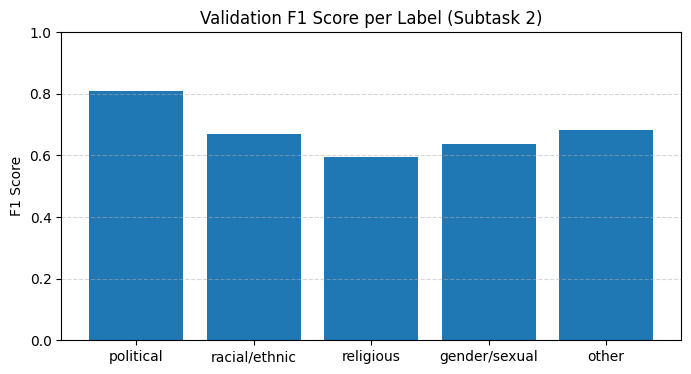

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(metrics_df["label"], metrics_df["f1"])
plt.ylabel("F1 Score")
plt.title("Validation F1 Score per Label (Subtask 2)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


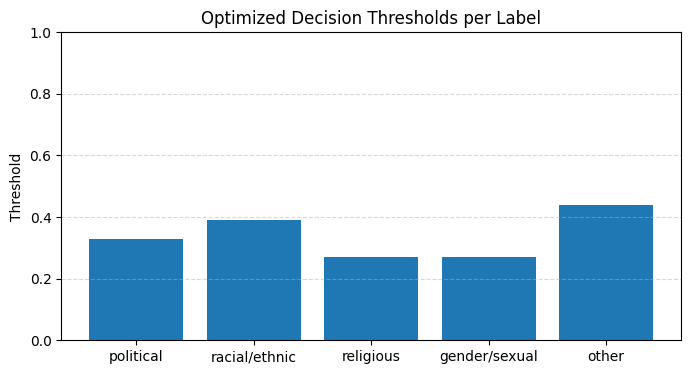

In [16]:
plt.figure(figsize=(8, 4))
plt.bar(LABEL_COLS, thr)
plt.ylabel("Threshold")
plt.title("Optimized Decision Thresholds per Label")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


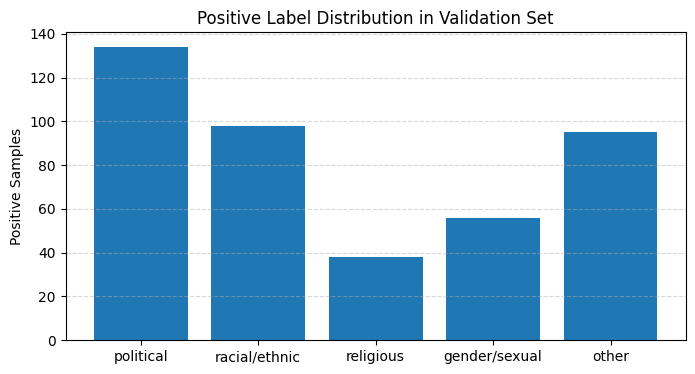

In [17]:
label_counts = val_y.sum(axis=0)

plt.figure(figsize=(8, 4))
plt.bar(LABEL_COLS, label_counts)
plt.ylabel("Positive Samples")
plt.title("Positive Label Distribution in Validation Set")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


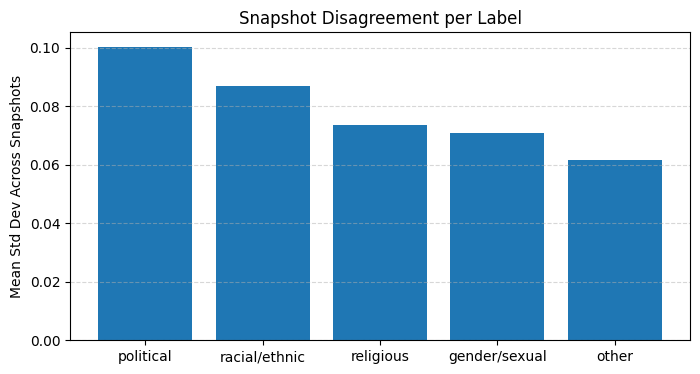

In [18]:
# snap_probs shape: (n_val, L, S)
# Compute std across snapshots
snapshot_std = snap_probs.std(axis=-1).mean(axis=0)

plt.figure(figsize=(8, 4))
plt.bar(LABEL_COLS, snapshot_std)
plt.ylabel("Mean Std Dev Across Snapshots")
plt.title("Snapshot Disagreement per Label")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [19]:
import pandas as pd

error_rows = []
for i, label in enumerate(LABEL_COLS):
    y_true = val_y[:, i]
    y_pred = val_preds[:, i]

    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    tn = ((y_true == 0) & (y_pred == 0)).sum()

    error_rows.append({
        "label": label,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

pd.DataFrame(error_rows)


,label,TP,FP,FN,TN
0,political,118,40,16,333
1,racial/ethnic,65,31,33,378
2,religious,22,14,16,455
3,gender/sexual,38,25,18,426
4,other,57,15,38,397


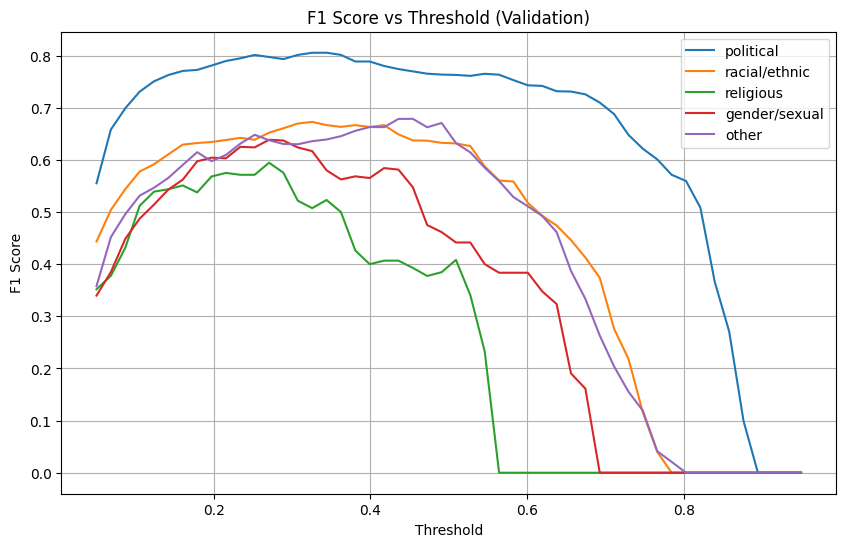

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

plt.figure(figsize=(10, 6))

thresholds = np.linspace(0.05, 0.95, 50)

for i, label in enumerate(LABEL_COLS):
    f1s = []
    for t in thresholds:
        preds = (val_meta_probs[:, i] >= t).astype(int)
        f1s.append(f1_score(val_y[:, i], preds, zero_division=0))

    plt.plot(thresholds, f1s, label=label)

plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold (Validation)")
plt.legend()
plt.grid(True)
plt.show()


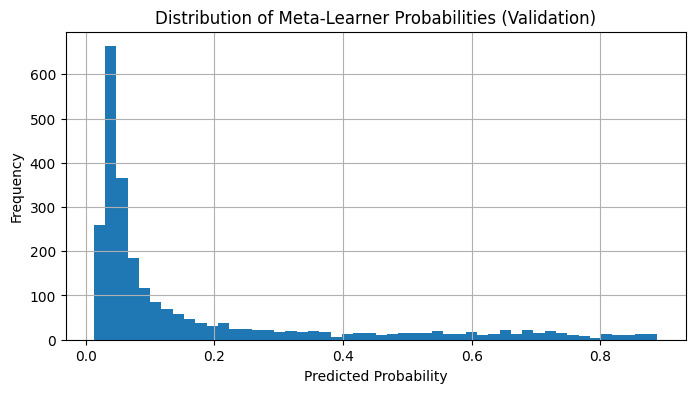

In [21]:
plt.figure(figsize=(8, 4))
plt.hist(val_meta_probs.flatten(), bins=50)
plt.title("Distribution of Meta-Learner Probabilities (Validation)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [22]:
# Add text back for inspection
val_texts = val_df[TRAIN_TEXT_COL].values

for i, label in enumerate(LABEL_COLS):
    print(f"\n=== Label: {label} ===")

    # False negatives
    fn_idx = np.where((val_y[:, i] == 1) & (val_preds[:, i] == 0))[0]
    if len(fn_idx) > 0:
        idx = fn_idx[0]
        print("False Negative example:")
        print(val_texts[idx][:300])



=== Label: political ===
False Negative example:
يا للخجل ٢٠ سنة و ما بتعرف مدن الدولة الي عايش فيها. بالله عليك لا تحكي من وين اصلك مش ناقصين فضايح

=== Label: racial/ethnic ===
False Negative example:
لو لطيفه توصل لربع صوت فله لجزاءريه انا بنتحر علنا لهلق بعدها لطيفه بتنشز انت فين و فله فين هههه

=== Label: religious ===
False Negative example:
الجزاءر تتكل علي الله وانتم تتكلون علي بني صهيون لو انت تتكلم عن السيادة المغربية اذهب وحرر سبتة و مليلية

=== Label: gender/sexual ===
False Negative example:
والله عيب...انتي لو ما فراش المنتجين و الملحنين ماكي فنانة...انتي مكانك في الملاهي يا سيدة الطرب ها ها ها ها

=== Label: other ===
False Negative example:
انتا عندك فوق براسك طير مش عقل لانك لو حاضر اللعبة وتارك كل احقادك ع جنب رح تشوف الحكم مع مين كان ولمين قدم فرص اكثر حبيبي اتركك من هوس ريال مدريد عشان صحتك


In [23]:
avg_probs = snap_probs.mean(axis=-1)  # simple average ensemble

avg_preds = np.zeros_like(val_y)
for j, t in enumerate(thr):
    avg_preds[:, j] = (avg_probs[:, j] >= t).astype(int)

avg_macro = f1_score(val_y, avg_preds, average="macro", zero_division=0)
meta_macro = f1_score(val_y, val_preds, average="macro", zero_division=0)

print(f"Average Ensemble Macro F1: {avg_macro:.4f}")
print(f"Meta-Learner Macro F1    : {meta_macro:.4f}")


Average Ensemble Macro F1: 0.3818
Meta-Learner Macro F1    : 0.6788


In [24]:
summary = {
    "Base Model": "MARBERTv2",
    "Task": "Subtask 2 – Polarization Type Classification",
    "Loss": "Asymmetric Loss",
    "Ensemble": f"{len(snapshot_dirs)} Snapshot Models",
    "Meta Learner": "One-vs-Rest Logistic Regression",
    "Thresholding": "Per-label F1-optimized",
    "Validation Macro F1": round(macro_f1, 4)
}

pd.DataFrame([summary])


,Base Model,Task,Loss,Ensemble,Meta Learner,Thresholding,Validation Macro F1
0,MARBERTv2,Subtask 2 – Polarization Type Classification,Asymmetric Loss,4 Snapshot Models,One-vs-Rest Logistic Regression,Per-label F1-optimized,0.6788


In [25]:
joblib.dump(meta, os.path.join(OUT_DIR, "meta_logreg.joblib"))

with open(os.path.join(OUT_DIR, "per_label_thresholds.json"), "w", encoding="utf-8") as f:
    json.dump({k: v for k, v in zip(LABEL_COLS, thr)}, f, ensure_ascii=False, indent=2)

with open(os.path.join(OUT_DIR, "snapshot_dirs.json"), "w", encoding="utf-8") as f:
    json.dump(snapshot_dirs, f, ensure_ascii=False, indent=2)

print("Saved artifacts in:", OUT_DIR)


Saved artifacts in: subtask2_ensemble


------------

In [26]:
import pandas as pd

DEV_CSV = "arb_clean_dev.csv"   # uploaded file
DEV_TEXT_COL = "text_clean"
ID_COL = "id"

dev_df = pd.read_csv(DEV_CSV)
dev_df.head()


,id,text_clean
0,arb_67be47e5216d7bee41e17484e619f4e6,حيل بيج يانذله تحجين ع العراقيات بس احنه العرا...
1,arb_272322e5b265e177613d685e5619e402,علي زبي\nيا ليتها تجي معي البر اخليها تسوق دبا...
2,arb_d1ec38dd0ec5d7a4fe28ef8317fc96c1,كل المغنين ولي يدخلون المسيقه في اغانيهم ن...
3,arb_fad75310b17c124d98ebc514189ec033,الله يخلق ونحنا نبتلي بكل ما تعنيه الكلامات من...
4,arb_95caf70cec5bf00c94c35cf7af2a0ab5,رءيس الدولة كافر والشعب ساكت خاطرو شعب طحان


In [27]:
import torch
from transformers import AutoTokenizer

MODEL_NAME = "UBC-NLP/MARBERTv2"
MAX_LEN = 256
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class UnlabeledTextDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, text_col, max_len=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, self.text_col])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {k: v.squeeze(0) for k, v in enc.items()}

dev_ds = UnlabeledTextDataset(dev_df, tokenizer, DEV_TEXT_COL, max_len=MAX_LEN)


In [28]:
import os

SNAPSHOT_ROOT = "subtask2_ensemble"  # where your snapshot_step_* folders are

snapshot_dirs = sorted([
    os.path.join(SNAPSHOT_ROOT, d)
    for d in os.listdir(SNAPSHOT_ROOT)
    if d.startswith("snapshot_step_")
])

snapshot_dirs


['subtask2_ensemble/snapshot_step_180',
 'subtask2_ensemble/snapshot_step_360',
 'subtask2_ensemble/snapshot_step_540',
 'subtask2_ensemble/snapshot_step_720']

In [29]:
import numpy as np
from transformers import AutoModelForSequenceClassification

def predict_probs(model_dir, dataset, batch_size=16, device="cuda"):
    m = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device)
    m.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_probs = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = m(**batch).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
    return np.vstack(all_probs)

dev_snap_probs = []
for d in snapshot_dirs:
    dev_snap_probs.append(predict_probs(d, dev_ds, batch_size=BATCH_SIZE))

dev_snap_probs = np.stack(dev_snap_probs, axis=-1)  # (n_dev, L, S)
dev_snap_probs.shape


(169, 5, 4)

In [30]:
# LABEL_COLS must match your task column names exactly
LABEL_COLS = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

X_dev = dev_snap_probs.reshape(len(dev_df), len(LABEL_COLS) * len(snapshot_dirs))

dev_meta_probs = meta.predict_proba(X_dev)  # meta must already exist in memory

dev_preds = np.zeros_like(dev_meta_probs, dtype=int)
for j, t in enumerate(thr):  # thr must already exist in memory
    dev_preds[:, j] = (dev_meta_probs[:, j] >= t).astype(int)

dev_preds.shape


(169, 5)

In [31]:
sub_df = pd.DataFrame(dev_preds, columns=LABEL_COLS)
sub_df.insert(0, "id", dev_df["id"].values)

SUBMISSION_PATH = "subtask2_dev_predictions.csv"
sub_df.to_csv(SUBMISSION_PATH, index=False)

print("Saved:", SUBMISSION_PATH)
sub_df.head()


Saved: subtask2_dev_predictions.csv


,id,political,racial/ethnic,religious,gender/sexual,other
0,arb_67be47e5216d7bee41e17484e619f4e6,0,1,0,1,1
1,arb_272322e5b265e177613d685e5619e402,0,0,0,1,0
2,arb_d1ec38dd0ec5d7a4fe28ef8317fc96c1,0,0,0,1,1
3,arb_fad75310b17c124d98ebc514189ec033,0,1,0,1,1
4,arb_95caf70cec5bf00c94c35cf7af2a0ab5,1,1,1,0,0
